In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
import geopandas as gpd
from matplotlib.lines import Line2D

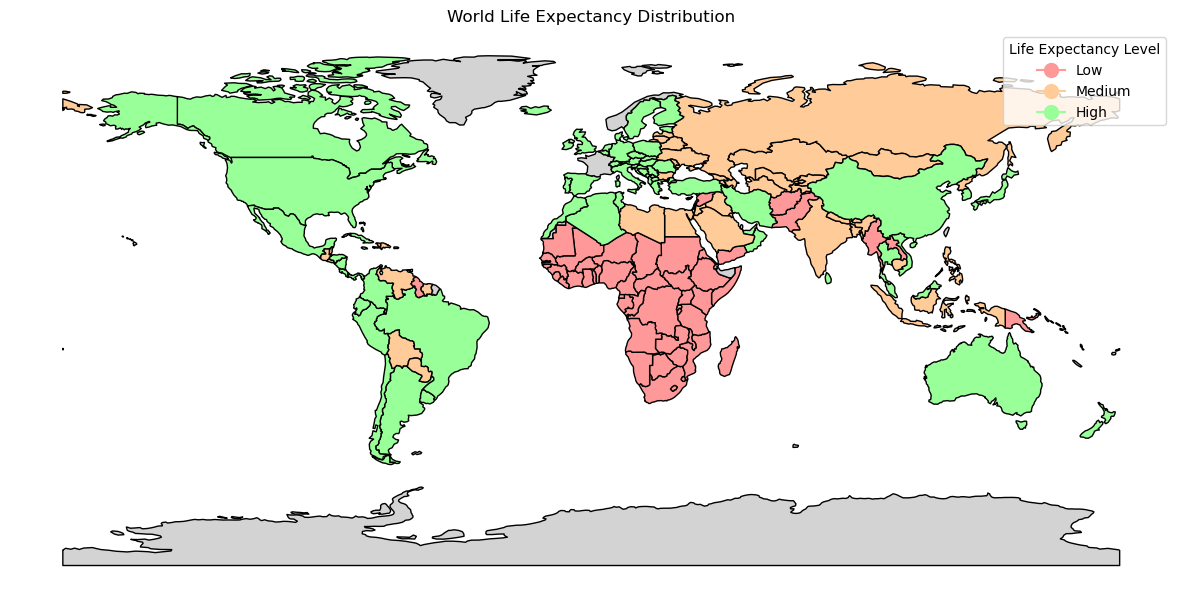

In [ ]:
#--------------------------------------------Prosessing--------------------------------------------#

# 1. Read life expectancy data
life_df = pd.read_csv('life.csv')

# 2. Get world map data
world = gpd.read_file('ne_110m_admin_0_countries.shp')

# Rename 'ISO_A3' to match
world = world.rename(columns={'ISO_A3': 'CountryCode'})

# 3. Data Merge
merged = world.merge(life_df, on='CountryCode', how='left')

# 4. Mapping
# Defining a Color Map
life_levels = ['Low', 'Medium', 'High']
colors = ['#ff9999', '#ffcc99', '#99ff99']
color_map = dict(zip(life_levels, colors))

# Assign colors to each level, handle NaN values
merged['Color'] = merged['Life expectancy at birth (years)'].map(color_map)
merged['Color'] = merged['Color'].fillna('#d3d3d3') 

# Mapping
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.plot(ax=ax, color=merged['Color'], edgecolor='black')

# Add legends
legend_elements = [Line2D([0], [0], marker='o', color=color, label=level, markersize=10)
                   for level, color in color_map.items()]
ax.legend(handles=legend_elements, title='Life Expectancy Level')

# Set Title
ax.set_title('World Life Expectancy Distribution')

# Remove the coordinate axis
ax.axis('off')

plt.show()

In [6]:
world_df = pd.read_csv('world.csv')
life_df = pd.read_csv('life.csv')

world_df['Year'] = world_df['Year'].astype(str)
life_df['Year'] = life_df['Year'].astype(str)

#Merge two datasets 
merged_df=pd.merge(world_df, life_df, on=['CountryName','CountryCode','Year'])  
merged_df.sort_values(by=['CountryName'], inplace=True)
merged_df.dropna(subset=['CountryName'],inplace=True)

X=merged_df.drop(columns=['CountryName','CountryCode','Year','Life expectancy at birth (years)'])
y=merged_df['Life expectancy at birth (years)']

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)  

#impute missing values
X_train=X_train.replace('..',np.nan)
X_test=X_test.replace('..',np.nan)  
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

#scale features
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [7]:
#--------------------------------------------Task A--------------------------------------------#

#training of K-NN(k=3) 
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train_scaled, y_train)
#test the classifier
y_pred_knn_3 = knn_3.predict(X_test_scaled)

#training of K-NN(k=7) 
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train_scaled, y_train)
#test the classifier
y_pred_knn_7 = knn_7.predict(X_test_scaled)

#training of Decision Tree
dt=DecisionTreeClassifier(max_depth=3)
dt.fit(X_train_scaled, y_train)
#test the classifier
y_pred_dt = dt.predict(X_test_scaled)

In [9]:
## Define parameter grid
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Create a GridSearchCV object for Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=100), 
                              param_grid=param_grid_rf, 
                              cv=3,n_jobs=-1,  verbose=1, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)
# Best parameters and best score
print("Random Forest-Best Parameters:",grid_search_rf.best_params_)
print("Random Forest-Best score:{:.2f}",grid_search_rf.best_score_)
# Evaluate on the test set
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)


# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
#Defining the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
#Get the best model
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss'), 
                           param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=1,scoring='accuracy')
grid_search_xgb.fit(X_train_scaled, y_train_encoded)
# Best parameters and best score
print(f'XGBoost-Best Parameters:{grid_search_xgb.best_params_}')
print(f'XGBoost-Best score:{grid_search_xgb.best_score_}')
#Train the best model
best_xgb=grid_search_xgb.best_estimator_
best_xgb.fit(X_train_scaled, y_train_encoded)
#Predict the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Random Forest-Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest-Best score:{:.2f} 0.755005005005005
Fitting 3 folds for each of 324 candidates, totalling 972 fits
XGBoost-Best Parameters:{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}
XGBoost-Best score:0.755005005005005


k-NN (k=3) Accuracy:0.6041666666666666
k-NN (k=7) Accuracy:0.6041666666666666
Decision Tree Accuracy:0.7708333333333334
Tuned Random Forest Accuracy:0.7291666666666666
Tuned XGBoost Accuracy:0.75


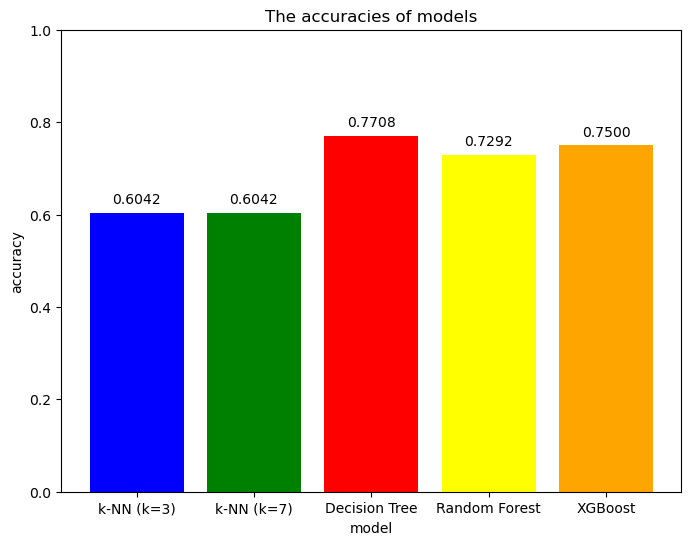

In [10]:
#calculate the accuracies
accuracy_knn_3 = accuracy_score(y_test, y_pred_knn_3)
print(f'k-NN (k=3) Accuracy:{accuracy_knn_3}')

accuracy_knn_7 = accuracy_score(y_test, y_pred_knn_7)
print(f'k-NN (k=7) Accuracy:{accuracy_knn_7}')

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy:{accuracy_dt}')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Tuned Random Forest Accuracy:{accuracy_rf}')

accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print(f'Tuned XGBoost Accuracy:{accuracy_xgb}')

# Accuracy results
accuracies = [accuracy_knn_3, accuracy_knn_7, accuracy_dt,accuracy_rf,accuracy_xgb]
# Model Name
models = ['k-NN (k=3)', 'k-NN (k=7)', 'Decision Tree','Random Forest','XGBoost']

# Draw a bar chart
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'yellow' , 'orange'])
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('The accuracies of models')
plt.ylim(0, 1)  # Set the range of the y-axis, the accuracy is between 0 and 1

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.02, f'{accuracy:.4f}', ha='center')  # Display accuracy values ​​on each bar
    
plt.show()

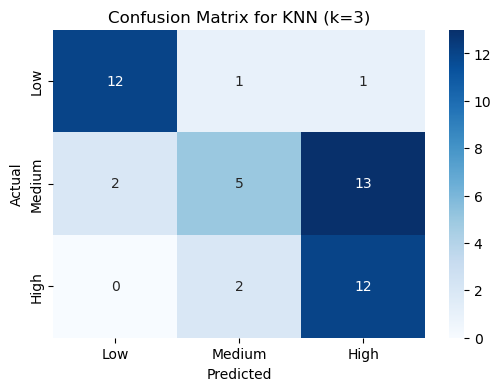

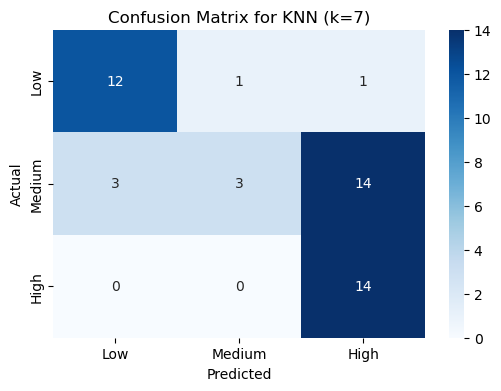

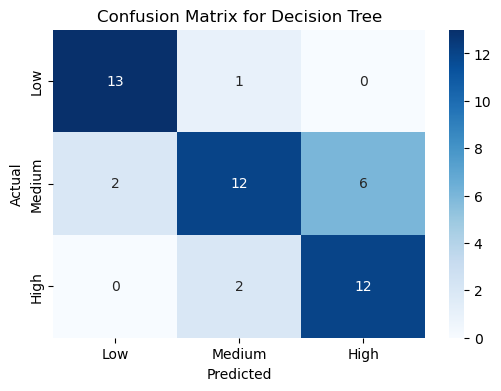

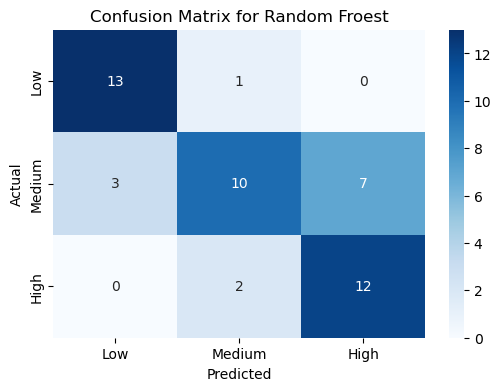

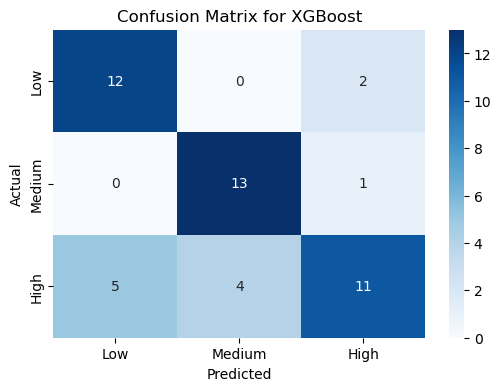

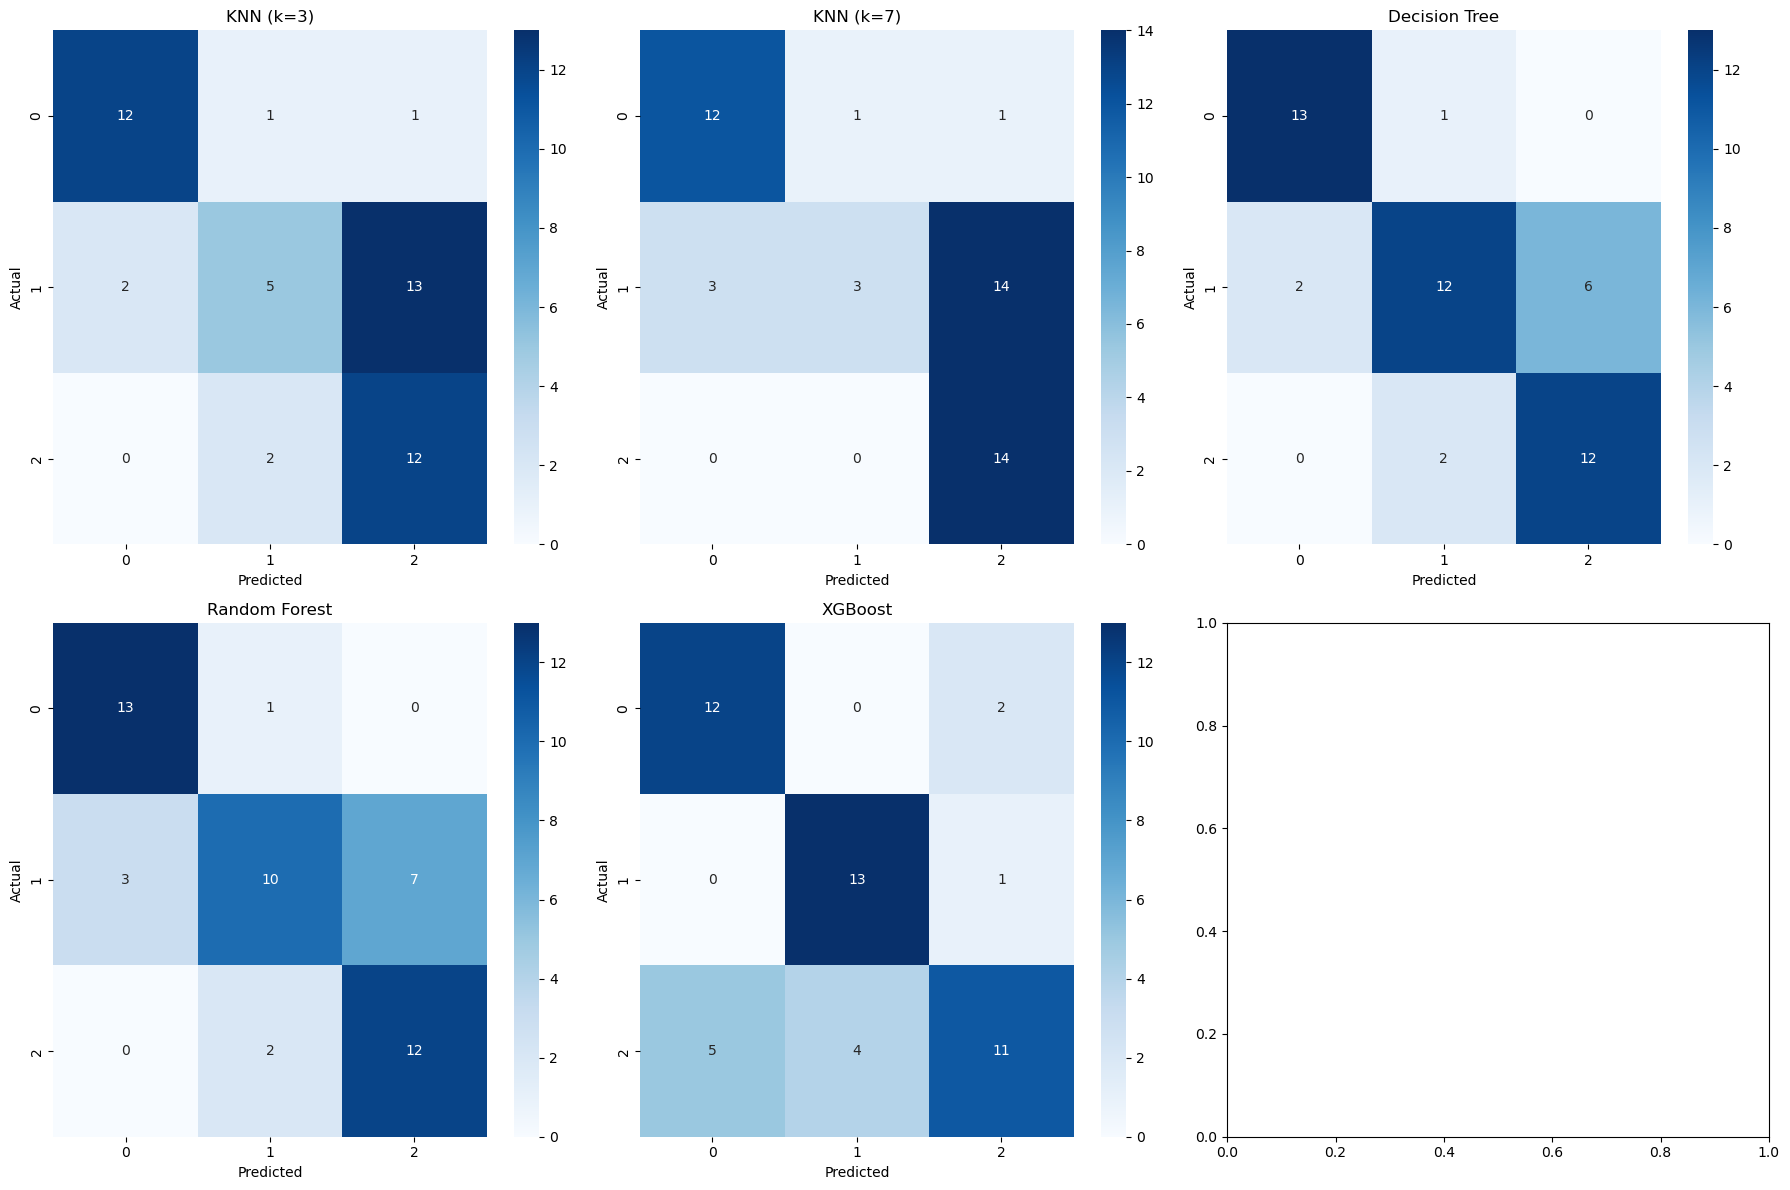

In [11]:
# calculate confusion matrix
conf_matrix_knn_3 = confusion_matrix(y_test, y_pred_knn_3, labels=['Low', 'Medium', 'High'])
conf_matrix_knn_7 = confusion_matrix(y_test, y_pred_knn_7, labels=['Low', 'Medium', 'High'])
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt, labels=['Low', 'Medium', 'High'])
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf, labels=['Low', 'Medium', 'High'])
conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb, labels=[0, 1, 2])

# draw confusion matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=['Low','Medium','High'],yticklabels=['Low','Medium','High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
plot_confusion_matrix(conf_matrix_knn_3, 'Confusion Matrix for KNN (k=3)')
plot_confusion_matrix(conf_matrix_knn_7, 'Confusion Matrix for KNN (k=7)')
plot_confusion_matrix(conf_matrix_dt, 'Confusion Matrix for Decision Tree')
plot_confusion_matrix(conf_matrix_rf, 'Confusion Matrix for Random Froest')
plot_confusion_matrix(conf_matrix_xgb, 'Confusion Matrix for XGBoost')


#draw the confusion matrixes together
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  

# draw each confusion matrix
titles = ['KNN (k=3)', 'KNN (k=7)', 'Decision Tree', 'Random Forest', 'XGBoost']
for i, (conf_matrix, title) in enumerate(zip([conf_matrix_knn_3, conf_matrix_knn_7, conf_matrix_dt, conf_matrix_rf, conf_matrix_xgb], titles)):
    row = i // 3  
    col = i % 3 
    ax = axs[row, col]
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

KNN (k=1) Accuracy: 0.6250	KNN (k=2) Accuracy: 0.5833	KNN (k=3) Accuracy: 0.6042	KNN (k=4) Accuracy: 0.6458	KNN (k=5) Accuracy: 0.6042	KNN (k=6) Accuracy: 0.6042	KNN (k=7) Accuracy: 0.6042	KNN (k=8) Accuracy: 0.5833	KNN (k=9) Accuracy: 0.6042	KNN (k=10) Accuracy: 0.6042	KNN (k=11) Accuracy: 0.6250	

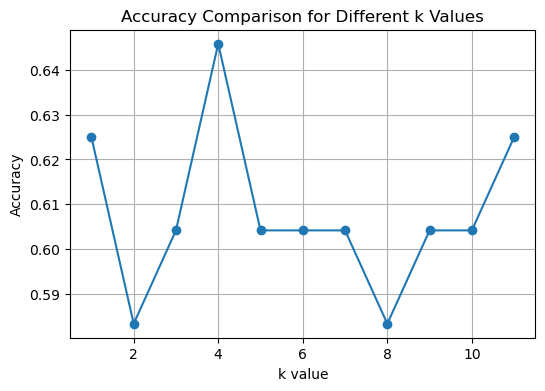

In [12]:
def train_multiple_knn(X_train, X_test, y_train, y_test, k_values):
    accuracies = {}
    models = {}
    
    for k in k_values:
        # Create and train model
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Predict and calculate accuracy
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        accuracies[k] = accuracy
        models[k] = knn
        
        # Print accuracy for each model
        print(f'KNN (k={k}) Accuracy: {accuracy:.4f}',end='\t')
    
    # Visualize accuracies for different k values
    plt.figure(figsize=(6, 4))
    plt.plot(list(accuracies.keys()), list(accuracies.values()), 'o-')
    plt.xlabel('k value')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison for Different k Values')
    plt.grid(True)
    
    plt.show()
    
    return accuracies, models

k_values = [1,2,3,4,5,6,7,8,9,10,11]
accuracies, models = train_multiple_knn(X_train_scaled, X_test_scaled, y_train, y_test, k_values)


Best k: 4
Best accuracy: 0.6458


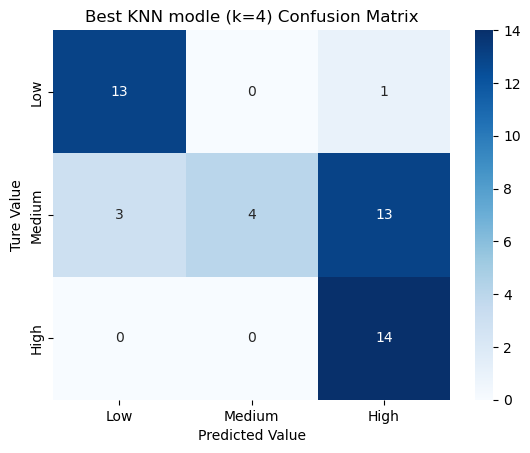

In [13]:
# Add best k annotation
best_k = max(accuracies, key=accuracies.get)
best_acc = accuracies[best_k]
plt.annotate(f'Best k={best_k}\nAccuracy={best_acc:.4f}',
                xy=(best_k, best_acc),
                xytext=(5, 5),
                textcoords='offset points')


# Find the best k value
best_k = max(accuracies, key=accuracies.get)
print(f'\nBest k: {best_k}')
print(f'Best accuracy: {accuracies[best_k]:.4f}')

# Draw the confusion matrix of the best model
best_model = models[best_k]
y_pred_best = best_model.predict(X_test_scaled)
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=['Low', 'Medium', 'High'])
sns.heatmap(conf_matrix, 
            annot=True, 
            cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Value')
plt.ylabel('Ture Value')
plt.title(f'Best KNN modle (k={best_k}) Confusion Matrix')

plt.show()

accuracy of Random Forest:0.7466666666666667
accuracy of XGBoost:0.7288888888888889
accuracy of Voting Classifier:0.7888888888888889


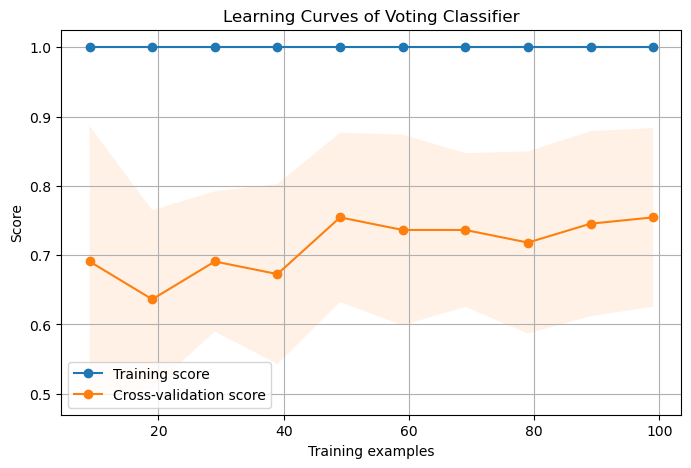

In [14]:
# Create basic Classifiers
clf1 = RandomForestClassifier(max_depth=4) 
clf2 = GradientBoostingClassifier(max_depth=3)
#clf3 = KNeighborsClassifier(n_neighbors=best_k)
clf3 = SVC(probability=True)

clf1.fit(X_train_scaled, y_train_encoded)
clf2.fit(X_train_scaled, y_train_encoded)
clf3.fit(X_train_scaled, y_train_encoded)

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', clf1), ('gb', clf2),('kn',clf3)],
    voting='soft'
)

# k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cross_val_scores = cross_val_score(best_rf, X_test_scaled, y_test_encoded, cv=kf)
print(f'accuracy of Random Forest:{rf_cross_val_scores.mean()}')

xgb_cross_val_scores = cross_val_score(best_xgb, X_test_scaled, y_test_encoded, cv=kf)
print(f'accuracy of XGBoost:{xgb_cross_val_scores.mean()}')

voing_cross_val_scores = cross_val_score(voting_clf, X_test_scaled, y_test_encoded, cv=kf)
print(f'accuracy of Voting Classifier:{voing_cross_val_scores.mean()}')

# Define the stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Draw learning curve
def plot_detailed_learning_curve(estimator, X, y):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, 
        cv=skf,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy'
    )
    
    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label="Cross-validation score")
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), 
                     alpha=0.1)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.title("Learning Curves of Voting Classifier")
    plt.legend(loc="best")
    plt.grid(True)
    
    plt.show()

plot_detailed_learning_curve(voting_clf, X_train_scaled, y_train_encoded)

Feature Importance of SelectKBest:
Access to electricity
Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions
People using at least basic drinking water services
People using at least basic drinking water services, rural
People using at least basic sanitation services, urban
Prevalence of anemia among children


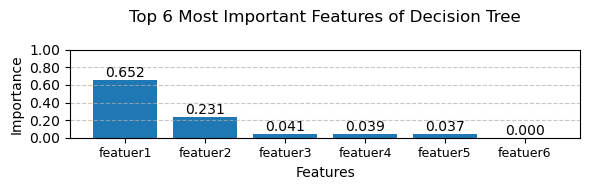

featuer1:
   Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions
featuer2:
   Adjusted net national income per capita
featuer3:
   Fertility rate, total
featuer4:
   Prevalence of anemia among children
featuer5:
   People using at least basic drinking water services, urban
featuer6:
   Wage and salaried workers, female


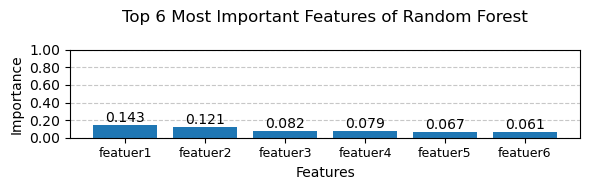

featuer1:
   Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions
featuer2:
   Lifetime risk of maternal death
featuer3:
   Access to electricity
featuer4:
   Prevalence of anemia among children
featuer5:
   People using at least basic sanitation services, urban
featuer6:
   People using at least basic drinking water services


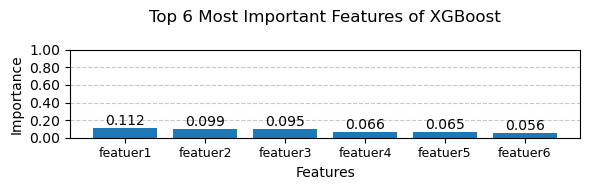

featuer1:
   Lifetime risk of maternal death
featuer2:
   Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions
featuer3:
   Prevalence of anemia among children
featuer4:
   Access to electricity
featuer5:
   People using at least basic drinking water services
featuer6:
   Individuals using the Internet


In [20]:
# Function to clean feature names
def clean_feature_name(name):
    # Remove the contents in square brackets [] and parentheses ()
    import re
    cleaned = re.sub(r'\[.*?\]', '', name)  # Remove the contents in square brackets
    cleaned = re.sub(r'\(.*?\)', '', cleaned)  # Remove the contents in parentheses
    return cleaned.strip()  # Remove extra spaces

# Feature importance visualization
def plot_feature_importance(model, features, model_name,top_n=6):
    # Show only the top N most important features
    importances = model.feature_importances_
    indices = np.argsort(importances)[:-(top_n+1):-1]  # Get the index of the top_n features

    # Assign a label to a specific feature name
    t=0
    feature_dict=dict()
    for i in indices:
        t=t+1
        feature_name="featuer"+str(t)
        feature_dict[feature_name]=features[i]
    
    plt.figure(figsize=(6, 2))
    
    # Plot the importance of the top_n features
    bars = plt.bar(range(top_n), importances[indices])
    
    plt.title(f"Top {top_n} Most Important Features of {model_name}", fontsize=12, pad=20)
    plt.xlabel("Features", fontsize=10)
    plt.ylabel("Importance", fontsize=10)
    
    # Set x-axis label
    plt.xticks(range(top_n), 
               [i for i in feature_dict.keys()],
               
               ha='center',
               fontsize=9)
    
    # Add specific values ​​to the column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
        
    # Adjust y-axis ticks
    ymin = 0
    ymax = np.ceil(np.max(importances[indices]))
    yticks = np.arange(ymin, ymax + 0.1, 0.2)
    plt.yticks(yticks, [f'{x:.2f}' for x in yticks])
    
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    #print the detailed feature
    for i in feature_dict:
        print(i,end=':\n   ')
        print(clean_feature_name(feature_dict[i]))

print("Feature Importance of SelectKBest:")
# Select the top 6 features
selector = SelectKBest(f_classif, k=6)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_encoded)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()]
for feature in selected_features:
    print(clean_feature_name(feature))

plot_feature_importance(dt, X.columns,"Decision Tree") #Feature importance of decision tree
plot_feature_importance(best_rf, X.columns,"Random Forest") #Feature importance of Random Forest
plot_feature_importance(best_xgb, X.columns, "XGBoost") #Feature importance of XGBoost

In [21]:
#--------------------------------------------Task B--------------------------------------------#

#20 original features
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
# Generate 190 interaction term features
def generate_interaction_terms(df):
    interactions = {}
    
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            col_name = f'interaction_{i}_{j}'
            interactions[col_name] = df.iloc[:, i] * df.iloc[:, j]
    
    # Convert the dictionary to a DataFrame
    return pd.DataFrame(interactions, index=df.index)

interaction_terms = generate_interaction_terms(pd.DataFrame(X_train_scaled))
interaction_terms_test = generate_interaction_terms(pd.DataFrame(X_test_scaled))

#Generate 1 feature by kmeans clustering
kmeans = KMeans(n_clusters=3, random_state=200)  
cluster_labels_train = kmeans.fit_predict(X_train_scaled)
cluster_labels_test=kmeans.predict(X_test_scaled)
cluster_labels_train=pd.DataFrame(cluster_labels_train,columns=['cluster_label'])
cluster_labels_test=pd.DataFrame(cluster_labels_test,columns=['cluster_label'])

#merge 211 features to extend the training and test set
X_train_extended=pd.concat([X_train_scaled_df,interaction_terms,cluster_labels_train],axis=1)
X_test_extended=pd.concat([X_test_scaled_df,interaction_terms_test,cluster_labels_test],axis=1)

d:\anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
#select 4 features by SelectKBest
selector = SelectKBest(f_classif, k=4)
X_train_select4best = selector.fit_transform(X_train_extended, y_train)
X_test_select4best = selector.transform(X_test_extended)
knn_3_select4best = KNeighborsClassifier(n_neighbors=3)
knn_3_select4best.fit(X_train_select4best, y_train)
y_pred_knn_3_select4best = knn_3_select4best.predict(X_test_select4best)
accuracy_knn_3_select4best = accuracy_score(y_test, y_pred_knn_3_select4best)
print(f'The accuracy of k-NN(k=3) selecting 4 features by SelectKBest:{accuracy_knn_3_select4best}')

#select via PCA by taking the first four principal components.
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_extended)
X_test_pca = pca.transform(X_test_extended)
knn_3_pca = KNeighborsClassifier(n_neighbors=3)
knn_3_pca.fit(X_train_pca, y_train)
y_pred_knn_3_pca = knn_3_pca.predict(X_test_pca)
accuracy_knn_3_pca = accuracy_score(y_test, y_pred_knn_3_pca)
print(f'The accuracy of k-NN(k=3) selecting via PCA:{accuracy_knn_3_pca}')

#Take the first four features from the original dataset
X_train_top4 = X_train_scaled_df.iloc[:, :4]
X_test_top4 = X_test_scaled_df.iloc[:, :4]
knn_3_top4 = KNeighborsClassifier(n_neighbors=3)
knn_3_top4.fit(X_train_top4, y_train)
y_pred_knn_3_top4 = knn_3_top4.predict(X_test_top4)
accuracy_knn_3_top4 = accuracy_score(y_test, y_pred_knn_3_top4)
print(f'The accuracy of k-NN(k=3) first four features from original dataset:{accuracy_knn_3_top4}')

#Next is Decision Tree
dt_select4best = DecisionTreeClassifier(max_depth=4)
dt_select4best.fit(X_train_select4best, y_train)
y_pred_dt_select4best = dt_select4best.predict(X_test_select4best)
accuracy_dt_select4best = accuracy_score(y_test, y_pred_dt_select4best)
print(f'The accuracy of Decision Tree selecting 4 features by SelectKBest:{accuracy_dt_select4best}')

dt_pca = DecisionTreeClassifier(max_depth=4)
dt_pca.fit(X_train_pca, y_train)
y_pred_dt_pca = dt_pca.predict(X_test_pca)
accuracy_dt_pca = accuracy_score(y_test, y_pred_dt_pca)
print(f'The accuracy of Decision Tree selecting via PCA:{accuracy_dt_pca}')

dt_top4 = DecisionTreeClassifier(max_depth=4)
dt_top4.fit(X_train_top4, y_train)
y_pred_dt_top4 = dt_top4.predict(X_test_top4)
accuracy_dt_top4 = accuracy_score(y_test, y_pred_dt_top4)
print(f'The accuracy of Decision Tree first four features from original dataset:{accuracy_dt_top4}')

The accuracy of k-NN(k=3) selecting 4 features by SelectKBest:0.7083333333333334
The accuracy of k-NN(k=3) selecting via PCA:0.5416666666666666
The accuracy of k-NN(k=3) first four features from original dataset:0.6041666666666666
The accuracy of Decision Tree selecting 4 features by SelectKBest:0.7291666666666666
The accuracy of Decision Tree selecting via PCA:0.5833333333333334
The accuracy of Decision Tree first four features from original dataset:0.625


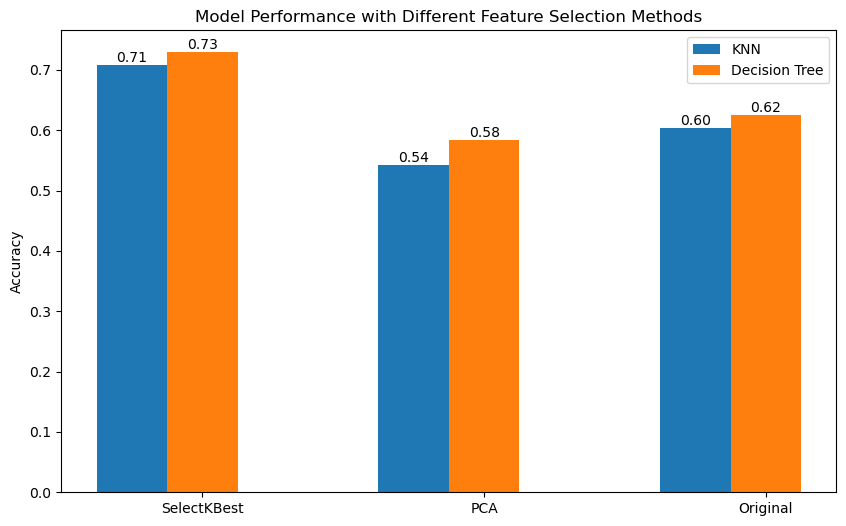

In [23]:
methods = ['SelectKBest', 'PCA', 'Original']
x = np.arange(len(methods))
width = 0.25

knn_accuracy = [accuracy_knn_3_select4best, accuracy_knn_3_pca, accuracy_knn_3_top4]
dt_accuracy = [accuracy_dt_select4best, accuracy_dt_pca, accuracy_dt_top4]

#draw the accuracies
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, knn_accuracy, width, label='KNN')
rects2 = ax.bar(x, dt_accuracy, width, label='Decision Tree')

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Different Feature Selection Methods')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

plt.show()

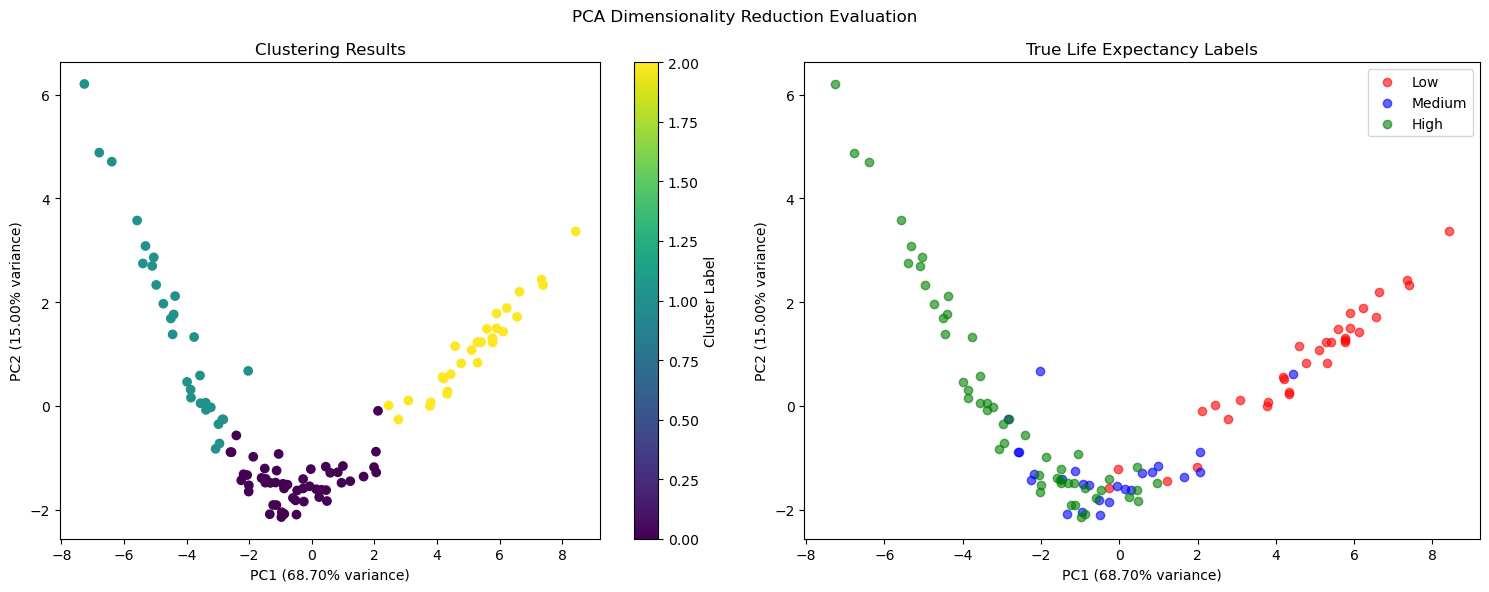

In [25]:
def visualize_clustering_evaluation(X_train_scaled, cluster_labels, y_train, title):
    # Perform PCA dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_scaled)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Show clustering results
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                          c=cluster_labels, 
                          cmap='viridis')
    ax1.set_title('Clustering Results')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter1, ax=ax1, label='Cluster Label')
    
    # 2. Show true labels
    for label, color in zip(['Low', 'Medium', 'High'], ['red', 'blue', 'green']):
        mask = y_train == label
        ax2.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=color, label=label, alpha=0.6)
    
    ax2.set_title('True Life Expectancy Labels')
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax2.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_clustering_evaluation(X_train_scaled, cluster_labels_train.values.ravel(), y_train, 'PCA Dimensionality Reduction Evaluation')

Cumulative variance explained: [0.43856659 0.74266108 0.78386707 0.81726727]


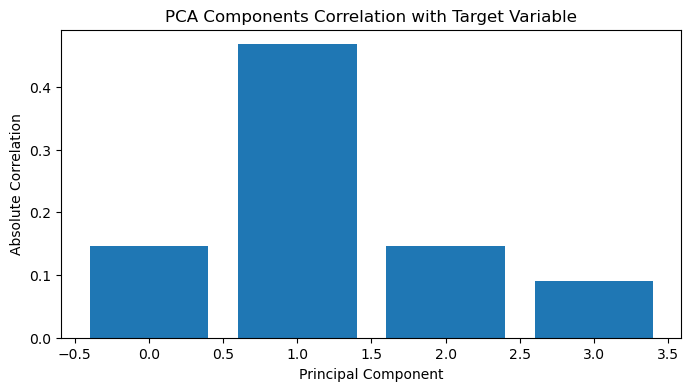

In [26]:
# Analyze the variance explained by PCA
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train_extended)
print("Cumulative variance explained:", np.cumsum(pca.explained_variance_ratio_))

# Check the correlation between the features after PCA transformation and the original labels
def analyze_pca_components(X_pca, y, n_components=4):
    correlations = []
    for i in range(n_components):
        correlation = np.corrcoef(X_pca[:, i], pd.get_dummies(y).values[:, 0])[0,1]
        correlations.append(abs(correlation))
    
    plt.figure(figsize=(8, 4))
    plt.bar(range(n_components), correlations)
    plt.title('PCA Components Correlation with Target Variable')
    plt.xlabel('Principal Component')
    plt.ylabel('Absolute Correlation')
    plt.show()

analyze_pca_components(X_train_pca, y_train)